## Notes

### Image
* Image size is 128 x 128

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as k
from PIL import Image
from tqdm.notebook import tqdm
import os
from sklearn import preprocessing
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, top_k_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

print(gpu_available, is_cuda_gpu_available)

False False


In [2]:
wandb.init(project="aircraft-project", entity="thompson_e")

wandb: Currently logged in as: thompson_e (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
batch_size = 128
img_height = 128
img_width = 128
epochs = 100

In [4]:
training_path = 'Train/'
label_file = 'train.csv'
image_path = 'Train/in_images'

y_ambi = set(['other-airplane', 'A220', 'Boeing787', 'Boeing777', 'Boeing737', 'Boeing747', 
                   'C919', 'A321', 'A350', 'A330', 'ARJ21'])
y_clean = labels_ambi = set(['A220', 'Boeing787', 'Boeing777', 'Boeing737', 'Boeing747', 
                   'C919', 'A321', 'A350', 'A330', 'ARJ21'])

In [5]:
# use this to limit the ambiguous choice of "other airplane"
USE_CLEAN = True

In [6]:
labels = pd.read_csv(f'{training_path}{label_file}')
if USE_CLEAN:
    labels = labels[labels.label != 'other-airplane']
labels = labels.to_numpy()

labels

array([['5690_0.png', 'A220'],
       ['5690_1.png', 'A220'],
       ['5690_2.png', 'A220'],
       ...,
       ['4597_0.png', 'Boeing737'],
       ['4597_1.png', 'A321'],
       ['4597_3.png', 'Boeing737']], dtype=object)

In [7]:
class Model:
    def __init__(self):
        self.model = self.build_model()
        print(self.model.summary())
    
    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer((128,128,3)),
            tf.keras.layers.Conv2D(filters = 8, kernel_size = 9),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(filters = 4, kernel_size = 3, activation = 'relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(.5),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [8]:
model = Model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 8)       1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 4)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3364)              0         
                                                                 
 dropout (Dropout)           (None, 3364)              0

In [13]:
X = []
for file in tqdm(labels[:,0]):
    image = Image.open(f'{image_path}/{file}')
    image = np.asarray(image)[:,:,:3]/255
    X.append(image)
X = np.array(X)

  0%|          | 0/20349 [00:00<?, ?it/s]

In [14]:
print(X.shape, labels.shape)

(20349, 128, 128, 3) (20349, 2)


In [15]:
le = preprocessing.LabelEncoder()
le.fit(labels[:,1])
print(le.classes_)
y = le.transform(labels[:,1])

['A220' 'A321' 'A330' 'A350' 'ARJ21' 'Boeing737' 'Boeing747' 'Boeing777'
 'Boeing787' 'C919']


In [20]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle = True, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, shuffle = True)

print(X_train.shape, X_test.shape, X_val.shape)

(16279, 128, 128, 3) (2849, 128, 128, 3) (1221, 128, 128, 3)


In [94]:
# model.model.fit(X_train, y_train, epochs=epochs,use_multiprocessing=True,verbose=1, 
#                 batch_size=batch_size, validation_data=(X_test,y_test) ,callbacks=[WandbCallback()])

Epoch 1/100
128/128 [==============================] - 42s 329ms/step - loss: 1.8762 - accuracy: 0.3129 - val_loss: 1.5964 - val_accuracy: 0.3952
Epoch 2/100
128/128 [==============================] - 41s 323ms/step - loss: 1.3071 - accuracy: 0.4924 - val_loss: 1.0851 - val_accuracy: 0.5865
Epoch 3/100
128/128 [==============================] - 41s 318ms/step - loss: 0.9984 - accuracy: 0.6174 - val_loss: 0.9140 - val_accuracy: 0.6364
Epoch 4/100
128/128 [==============================] - 41s 319ms/step - loss: 0.7667 - accuracy: 0.7111 - val_loss: 0.6160 - val_accuracy: 0.7919
Epoch 5/100
128/128 [==============================] - 41s 320ms/step - loss: 0.6319 - accuracy: 0.7702 - val_loss: 0.4639 - val_accuracy: 0.8484
Epoch 6/100
128/128 [==============================] - 41s 319ms/step - loss: 0.5096 - accuracy: 0.8174 - val_loss: 0.3990 - val_accuracy: 0.8680
Epoch 7/100
128/128 [==============================] - 42s 332ms/step - loss: 0.4334 - accuracy: 0.8473 - val_loss: 0.4143 -

Epoch 57/100
128/128 [==============================] - 41s 323ms/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 0.1947 - val_accuracy: 0.9572
Epoch 58/100
128/128 [==============================] - 42s 332ms/step - loss: 0.0620 - accuracy: 0.9791 - val_loss: 0.1831 - val_accuracy: 0.9579
Epoch 59/100
128/128 [==============================] - 41s 319ms/step - loss: 0.0588 - accuracy: 0.9800 - val_loss: 0.1991 - val_accuracy: 0.9596
Epoch 60/100
128/128 [==============================] - 41s 324ms/step - loss: 0.0565 - accuracy: 0.9834 - val_loss: 0.1951 - val_accuracy: 0.9603
Epoch 61/100
128/128 [==============================] - 42s 327ms/step - loss: 0.0513 - accuracy: 0.9831 - val_loss: 0.2205 - val_accuracy: 0.9565
Epoch 62/100
128/128 [==============================] - 41s 321ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.2080 - val_accuracy: 0.9568
Epoch 63/100
128/128 [==============================] - 42s 326ms/step - loss: 0.0581 - accuracy: 0.9806 - val_loss: 0

In [25]:
model.model.evaluate(X_val, y_val)  

39/39 [==============================] - 1s 15ms/step - loss: 0.0220 - accuracy: 0.9934


[0.02196679636836052, 0.99344801902771]

In [26]:
preds = model.model.predict(X_val)
p = np.argmax(preds, axis=1)

correct = 0

for i in range(len(p)):
    if p[i] == y_val[i]:
        correct += 1
print(correct, len(p)-correct, len(p))
print(f'Overall Accuracy: {((correct/len(p))*100):.2f}%')

1213 8 1221
Overall Accuracy: 99.34%


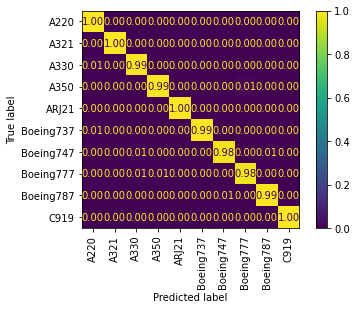

In [19]:
cm = confusion_matrix(y_val,p, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
d = disp.plot(xticks_rotation='vertical', values_format='.2f')

In [101]:
# model.model.save('95-accuracy')
model.model.save('95-accuracy.h5')


39/39 [==============================] - 1s 16ms/step - loss: 0.0220 - accuracy: 0.9934
1213 8 1221
Overall Accuracy: 99.34%


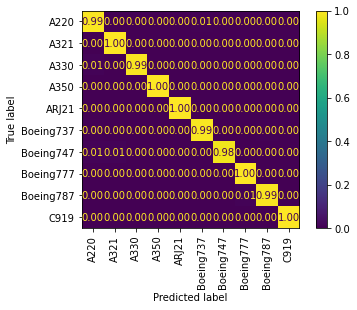

In [27]:
model.model.load_weights('95-accuracy.h5')
model.model.evaluate(X_val, y_val)
preds = model.model.predict(X_val)
p = np.argmax(preds, axis=1)

correct = 0

for i in range(len(p)):
    if p[i] == y_val[i]:
        correct += 1
print(correct, len(p)-correct, len(p))
print(f'Overall Accuracy: {((correct/len(p))*100):.2f}%')

cm = confusion_matrix(y_val,p, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
d = disp.plot(xticks_rotation='vertical', values_format='.2f')

In [35]:
accuracy_score(y_val, p)

0.9934479934479934

In [42]:
f1_score(y_val, p, average='macro')

0.9949854860632413

In [46]:
precision_score(y_val,p, average='macro')

0.9955805089621315

In [51]:
top_k_accuracy_score(y_val, preds, k=3)

1.0